In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

# import wandb

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")
print(DEVICE)

cuda:0


In [3]:
import zipfile
import os

# 압축 파일과 압축 해제 경로
zip_file_path = 'CUB_200_2011_repackage_class50.zip'
extract_to = 'CUB_200_2011_class50'

# 폴더가 존재하지 않으면 생성
os.makedirs(extract_to, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"'{zip_file_path}' 파일이 '{extract_to}' 폴더에 성공적으로 압축 해제되었습니다.")


FileNotFoundError: [Errno 2] No such file or directory: 'CUB_200_2011_repackage_class50.zip'

In [4]:
### Custom Dataset ###
class CUB2011(Dataset):
    def __init__(self, transform, mode='train'):
        self.transform = transform
        self.mode = mode
        base_path = 'datasets'  # 기본 경로 설정

        if self.mode == 'train':
            folder_path = os.path.join(base_path, 'train')
        elif self.mode == 'valid':
            folder_path = os.path.join(base_path, 'valid')
        elif self.mode == 'test':
            folder_path = os.path.join(base_path, 'test')

        # 디렉토리 제외하고 파일만 리스트에 포함
        self.image_folder = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = Image.open(os.path.join('datasets/', self.mode, img_path)).convert('RGB')
        img = self.transform(img)

        # 라벨을 이미지 파일명에서 추출 (예: 파일명이 'image_3.jpg'일 때 라벨은 3)
        label = img_path.split('_')[-1].split('.')[0]
        label = int(label)
        return img, label

In [5]:
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms

# 데이터 변환 정의
transforms_train = transforms.Compose([
    transforms.Resize((448, 448)),              # 크기 조정
    transforms.RandomRotation(15),              # 무작위 회전
    transforms.RandomResizedCrop(448, scale=(0.8, 1.0)),  # 무작위 크롭
    transforms.RandomHorizontalFlip(p=0.5),     # 좌우 반전
    transforms.ToTensor(),                      # 텐서 변환
])

transforms_valtest = transforms.Compose([
    transforms.Resize((448, 448)),              # 크기 조정
    transforms.ToTensor(),                      # 텐서 변환
])


In [6]:
from torch.utils.data import ConcatDataset, DataLoader

# 기본 Train 데이터셋
org_train_set = CUB2011(mode='train', transform=transforms_valtest)  # 기본 크기 조정만 적용

# 증강된 Train 데이터셋
transformed_train_set = CUB2011(mode='train', transform=transforms_train)

# 기본 데이터셋과 증강 데이터셋을 결합
train_set = ConcatDataset([org_train_set, transformed_train_set])



# Validation 및 Test 데이터셋
val_set = CUB2011(mode='valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)

# 데이터셋 크기 확인
print('Num of each dataset:', len(org_train_set), len(val_set), len(test_set))

# DataLoader 정의
BATCH_SIZE = 32
train_loader = DataLoader(org_train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Loaded combined dataloader")

Num of each dataset: 2360 296 298
Loaded combined dataloader


In [7]:
### Model / Optimzier ###
EPOCH = 100
lr = 0.001

In [8]:
model = models.resnet18(pretrained=True)

### Transfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 50)

params_to_update = []
for name, param in model.named_parameters():
    if 'fc' in name:
        print(name)
        print(param.requires_grad)
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

model.to(DEVICE)
optimizer = optim.Adam(params_to_update, lr=lr)
print("Created a learning model and optimizer")

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fc.weight
True
fc.bias
True
Created a learning model and optimizer


In [9]:
import wandb

# wandb 초기화 (프로젝트 이름 설정)
wandb.init(project="resnet18")

### Train/Evaluation with wandb logging ###
def train(model, train_loader, optimizer, epoch):
    model.train()
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        train_loss = F.cross_entropy(output, target).to(DEVICE)
        train_loss.backward()
        optimizer.step()

        # 매 10번째 배치마다 로그 남기기
        if i % 10 == 0:
            print(f'Train Epoch : {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item(): .6f}')
            wandb.log({"train_loss": train_loss.item(), "epoch": epoch})
    return train_loss

def evaluate(model, val_loader):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            eval_loss += F.cross_entropy(output, target, reduction= 'sum').item()
            pred = output.argmax(1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    eval_loss /= len(val_loader.dataset)
    eval_accuracy = 100 * correct / len(val_loader.dataset)

    # validation 결과 wandb에 기록
    wandb.log({"val_loss": eval_loss, "val_accuracy": eval_accuracy})
    return eval_loss, eval_accuracy

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tkdgjs1315 (gachon-university-fdslab). Use `wandb login --relogin` to force relogin


In [10]:
def train_model_sweep(config=None):
    with wandb.init(config=config):  # wandb.init()을 통해 설정된 하이퍼파라미터 사용
        config = wandb.config

        # 모델, 옵티마이저 및 손실 함수 정의
        model = models.resnet18(pretrained=True).to(DEVICE)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 50).to(DEVICE)  # assuming 50 classes

        params_to_update = model.parameters()
        if config.optimizer == 'adam':
            optimizer = optim.Adam(params_to_update, lr=config.learning_rate)
        elif config.optimizer == 'sgd':
            optimizer = optim.SGD(params_to_update, lr=config.learning_rate)
        elif config.optimizer == 'rmsprop':
            optimizer = optim.RMSprop(params_to_update, lr=config.learning_rate)


        best_val_acc = 0
        no_improvement_epochs = 0
        early_stopping_patience = 8

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            total_loss = 0
            for i, (images, targets) in enumerate(train_loader):
                images, targets = images.to(DEVICE), targets.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(images)
                loss = F.cross_entropy(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                if i % 10 == 0:
                    print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}")
                    wandb.log({"train_loss": loss.item(), "epoch": epoch})

            # Validation 단계
            val_loss, val_accuracy = evaluate(model, val_loader)
            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
            wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})

            # 최적의 모델 저장
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                torch.save(model.state_dict(), "best_model.pth")
                wandb.log({"best_val_accuracy": best_val_acc})
                no_improvement_epochs = 0  # 최고 성능 업데이트 시 초기화
            else:
                no_improvement_epochs += 1  # 성능이 향상되지 않은 에포크 수 증가

            # 조기 종료 조건 확인
            if no_improvement_epochs >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
        # Test result
        test_loss, test_accuracy = evaluate(model, test_loader)
        print(f'[FINAL] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
        wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})


In [12]:
# 하이퍼파라미터 스윕 설정
sweep_config = {
    'name' : 'resnet18-No-preprocess',
    'method': 'grid',  # 'random' 또는 'bayes'도 가능
    'metric': {
        'name': 'val_accuracy',  # 최적화할 메트릭
        'goal': 'maximize'  # 성능을 최대화하려는 목표
    },
    'parameters': {
        'epochs': {
            'value': 50  # 실험할 epoch 수
        },
        'batch_size': {
            'values': [16, 32, 64]  # 실험할 배치 사이즈
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]  # 실험할 learning rate
        },
        'optimizer': {
            'values': ['sgd', 'rmsprop', 'adam']  # 사용할 optimizer
        }
    }
}

# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="resnet18")


Create sweep with ID: ow2ambg7
Sweep URL: https://wandb.ai/gachon-university-fdslab/resnet18/sweeps/ow2ambg7


In [ ]:
# Sweep 시작
wandb.agent(sweep_id, train_model_sweep)  # count=10은 10개의 실험을 수행하겠다는 의미

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: aacxqlr2 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 4.0241
Epoch: 0, Batch: 10, Loss: 3.9217
Epoch: 0, Batch: 20, Loss: 3.7411
Epoch: 0, Batch: 30, Loss: 3.7625
Epoch: 0, Batch: 40, Loss: 3.7532
Epoch: 0, Batch: 50, Loss: 3.6137
Epoch: 0, Batch: 60, Loss: 3.5362
Epoch: 0, Batch: 70, Loss: 3.4329
Validation Loss: 3.3711, Accuracy: 18.5811
Epoch: 1, Batch: 0, Loss: 3.2397
Epoch: 1, Batch: 10, Loss: 3.1604
Epoch: 1, Batch: 20, Loss: 3.2489
Epoch: 1, Batch: 30, Loss: 3.0037
Epoch: 1, Batch: 40, Loss: 2.7670
Epoch: 1, Batch: 50, Loss: 2.9985
Epoch: 1, Batch: 60, Loss: 3.1656
Epoch: 1, Batch: 70, Loss: 2.9728
Validation Loss: 2.8489, Accuracy: 35.4730
Epoch: 2, Batch: 0, Loss: 2.5876
Epoch: 2, Batch: 10, Loss: 2.6836
Epoch: 2, Batch: 20, Loss: 2.7028
Epoch: 2, Batch: 30, Loss: 2.5783
Epoch: 2, Batch: 40, Loss: 2.6005
Epoch: 2, Batch: 50, Loss: 2.3051


In [75]:
import time
import torch

# Training Loop
start = time.time()
best = 0

model = model.to(DEVICE)  # 모델을 CUDA로 이동
for epoch in range(EPOCH):
    train_loss = train(model, train_loader, optimizer, epoch)
    val_loss, val_accuracy = evaluate(model, val_loader)

    # Save best model
    if val_accuracy > best:
        best = val_accuracy
        torch.save(model.state_dict(), "./best_model.pth")
        print(f'Best model saved with accuracy: {best:.4f}')

    # Log to WandB
    wandb.log({"best_val_accuracy": best, "val_loss": val_loss, "epoch": epoch})

    print(f'[{epoch}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Test result
test_loss, test_accuracy = evaluate(model, test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})

end = time.time()
elapsed_time = end - start
print(f'Elapsed Time: {int(elapsed_time / 3600)}h, {int((elapsed_time % 3600) / 60)}m, {int(elapsed_time % 60)}s')


Train Epoch : 0 [0/148]	Loss:  4.069055
Train Epoch : 0 [10/148]	Loss:  3.923494
Train Epoch : 0 [20/148]	Loss:  4.206474
Train Epoch : 0 [30/148]	Loss:  4.129817
Train Epoch : 0 [40/148]	Loss:  4.148136
Train Epoch : 0 [50/148]	Loss:  4.111498
Train Epoch : 0 [60/148]	Loss:  4.188323
Train Epoch : 0 [70/148]	Loss:  3.841141
Train Epoch : 0 [80/148]	Loss:  4.093532
Train Epoch : 0 [90/148]	Loss:  3.873890
Train Epoch : 0 [100/148]	Loss:  4.124829
Train Epoch : 0 [110/148]	Loss:  4.066699
Train Epoch : 0 [120/148]	Loss:  4.020761
Train Epoch : 0 [130/148]	Loss:  4.032949
Train Epoch : 0 [140/148]	Loss:  4.073379
Best model saved with accuracy: 2.0270
[0] Validation Loss: 4.0575, Accuracy: 2.0270
Train Epoch : 1 [0/148]	Loss:  3.957337
Train Epoch : 1 [10/148]	Loss:  4.034312
Train Epoch : 1 [20/148]	Loss:  3.775929


KeyboardInterrupt: 

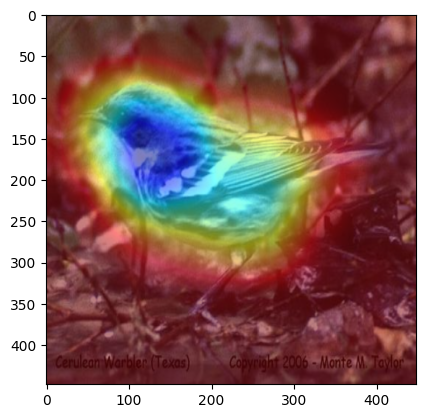

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Grad-CAM 클래스
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self):
        # Gradients와 activations을 활용하여 CAM 생성
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        weights = np.mean(gradients, axis=(2, 3))[0, :]
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]

        cam = np.maximum(cam, 0)  # ReLU 적용
        cam = cv2.resize(cam, (448, 448))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Grad-CAM 적용 및 시각화
def apply_gradcam(model, image, target_layer):
    model.eval()
    image = image.to(DEVICE).unsqueeze(0)

    gradcam = GradCAM(model, target_layer)

    # Forward pass
    output = model(image)
    pred = output.argmax(dim=1)

    # Backward pass
    model.zero_grad()
    output[0, pred].backward()

    cam = gradcam.generate_cam()

    # 원본 이미지와 CAM overlay
    img_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = np.float32(cam) / 255
    cam_output = cam + np.float32(img_np)
    cam_output = cam_output / np.max(cam_output)

    plt.imshow(cam_output)
    plt.show()

# 예시로 첫 번째 이미지를 대상으로 Grad-CAM 적용
image, label = next(iter(test_loader))
apply_gradcam(model, image[3], model.layer4[1].conv2)  # ResNet-18의 layer4[1]에 적용


Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


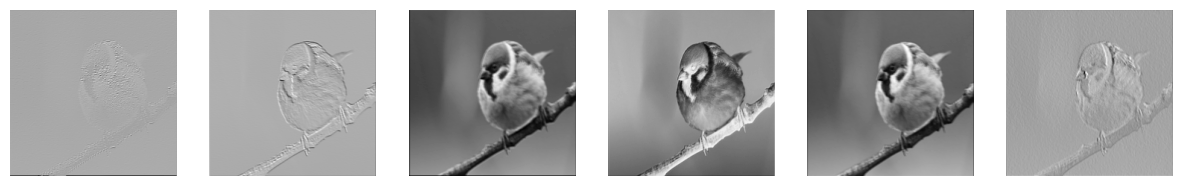

Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


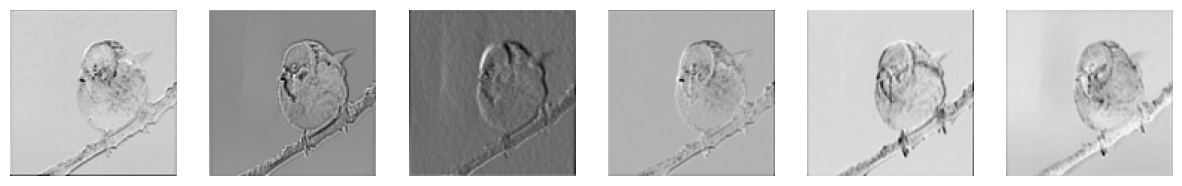

Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


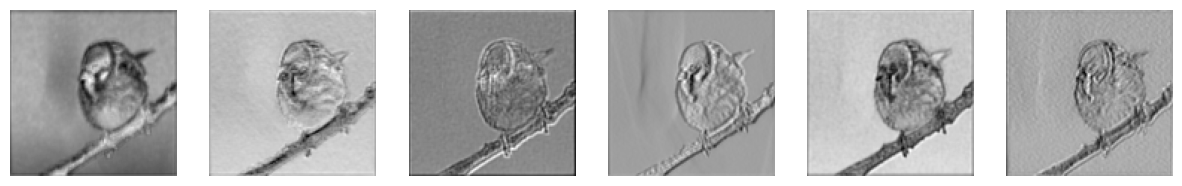

Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


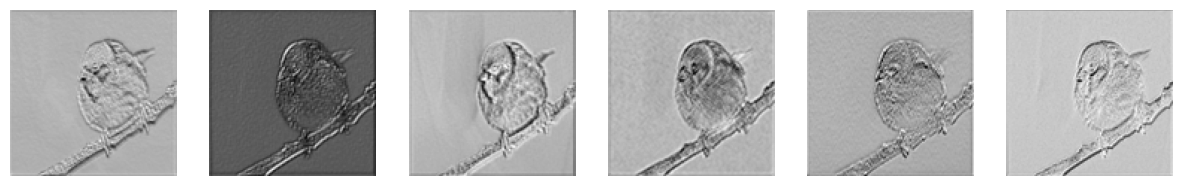

Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


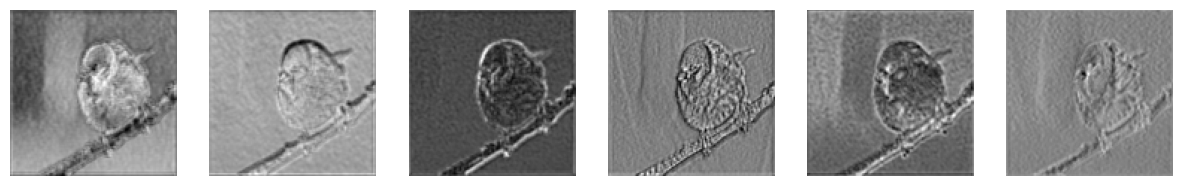

Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


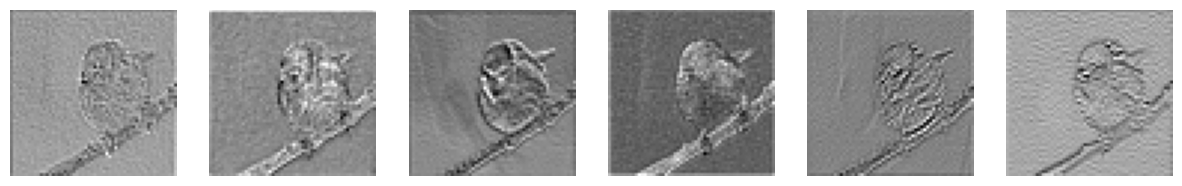

Layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


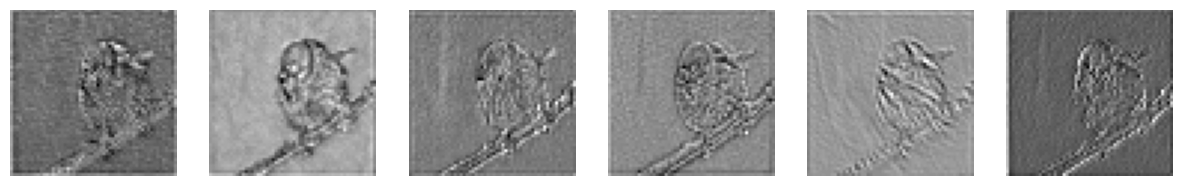

Layer: Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)


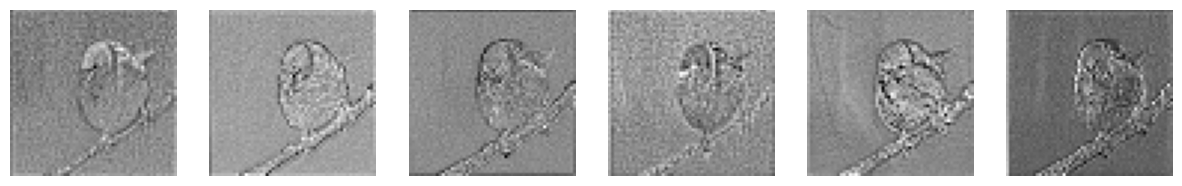

Layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


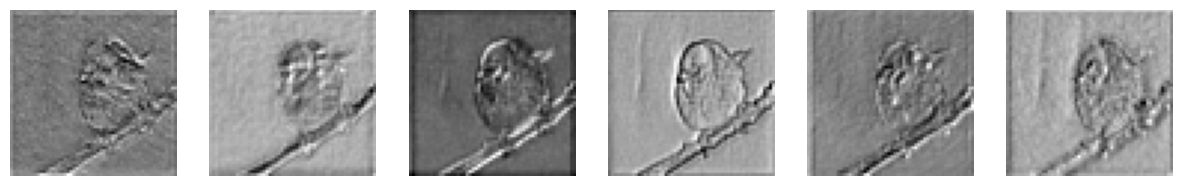

Layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


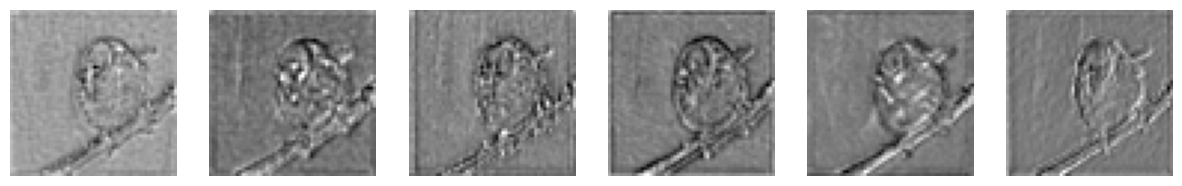

Layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


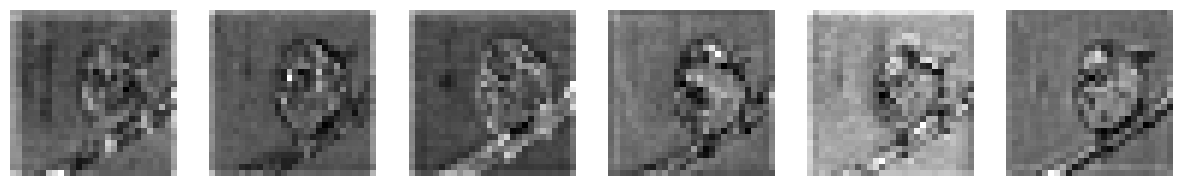

Layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


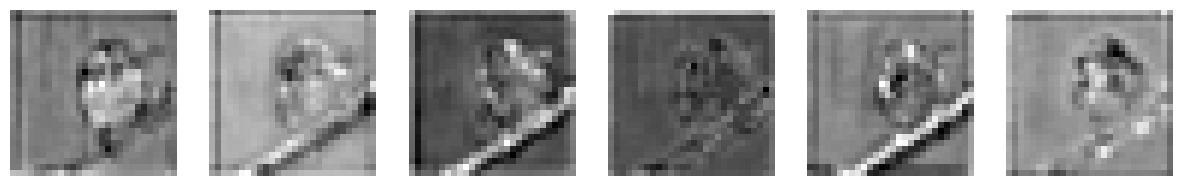

Layer: Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)


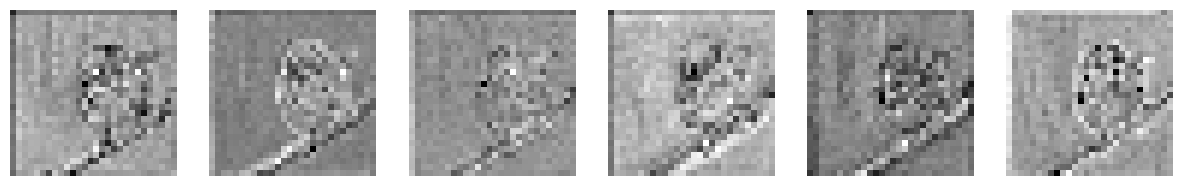

Layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


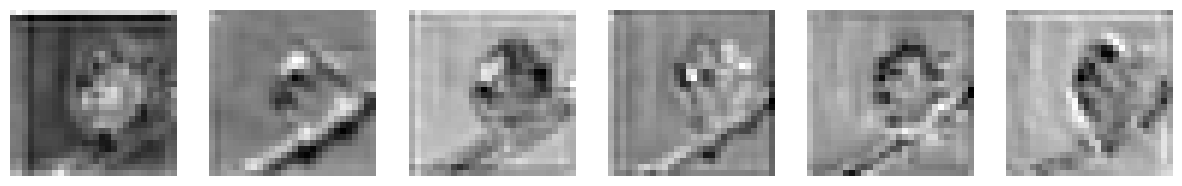

Layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


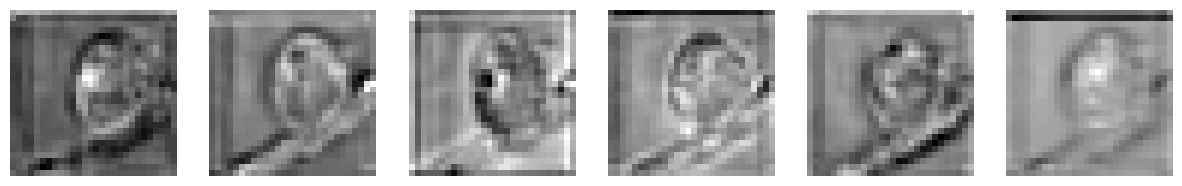

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


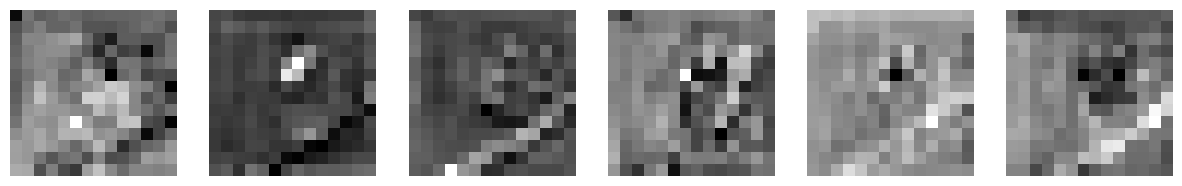

Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


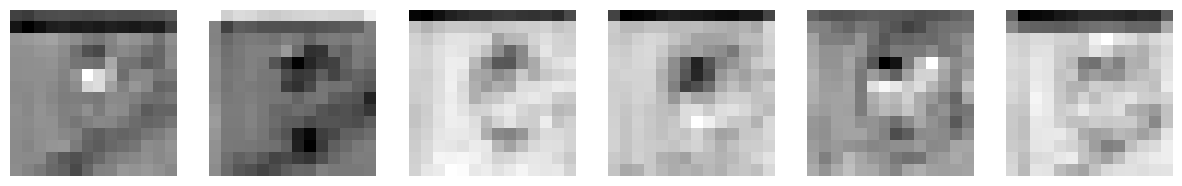

Layer: Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)


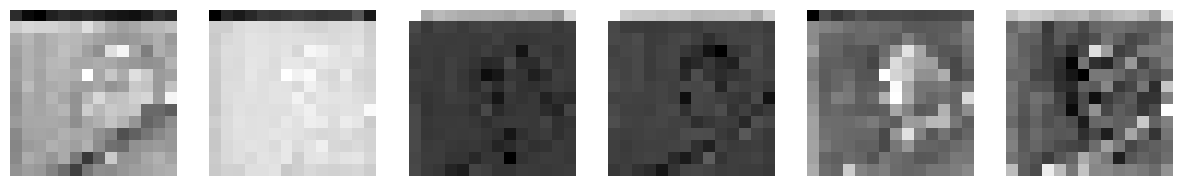

Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


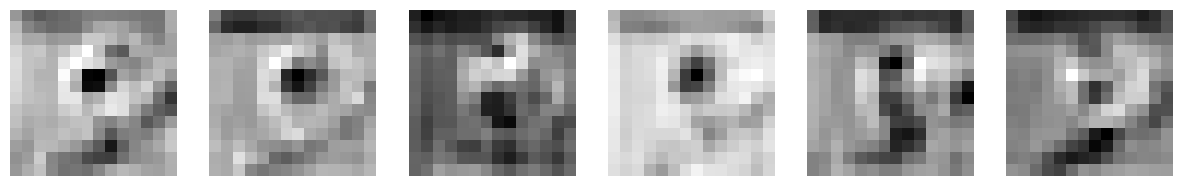

Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


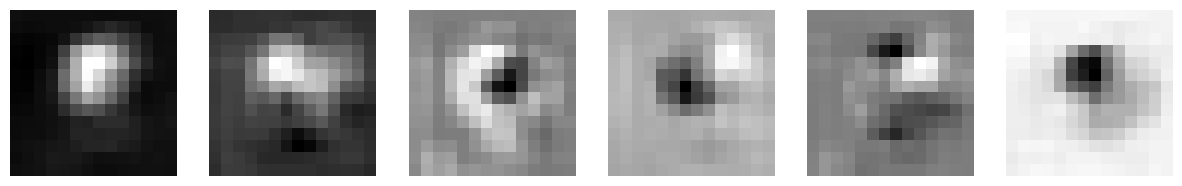

Layer: Linear(in_features=512, out_features=50, bias=True)


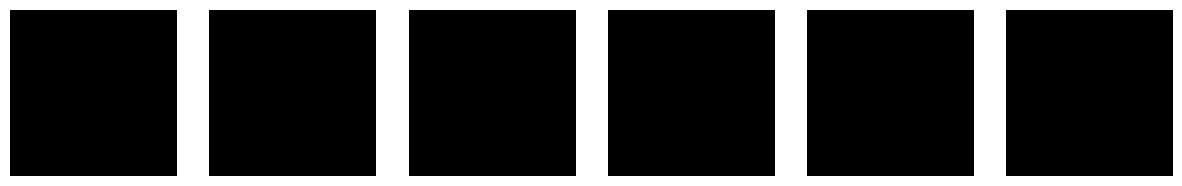

In [38]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 저장할 feature map 딕셔너리
feature_maps = {}

# Forward Hook 함수
def forward_hook(module, input, output):
    feature_maps[module] = output

# 모델의 각 레이어에 forward hook 등록
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):  # Conv 레이어와 Linear 레이어에 대해
        layer.register_forward_hook(forward_hook)

sample_input, _ = next(iter(test_loader))
sample_input = sample_input.to(DEVICE)

# 모델에 샘플 이미지 통과
with torch.no_grad():
    model(sample_input)

# 각 레이어의 출력값 시각화
for layer, fmap in feature_maps.items():
    print(f"Layer: {layer}")
    fmap = fmap.cpu().numpy()  # 출력값을 numpy로 변환
    num_filters = fmap.shape[1]  # 필터 개수 확인

    # 첫 번째 레이어라면 이미지형 출력이므로 첫 6개 필터 시각화
    fig, axes = plt.subplots(1, 6, figsize=(15, 15))
    for i in range(6):
        if len(fmap.shape) == 4:  # (B, C, H, W) 형태의 특징 맵
            feature = fmap[0, i, :, :]  # 첫 번째 배치의 i번째 필터
            axes[i].imshow(feature, cmap='gray')
        else:  # Linear Layer (Flatten된 벡터)
            feature = fmap[0, i]  # 첫 번째 배치의 i번째 뉴런 값
            axes[i].imshow(feature.reshape(1, -1), cmap='gray')  # 1차원 벡터는 시각화를 위해 reshape
        axes[i].axis('off')
    plt.show()


Visualizing Conv Layer: conv1.weight with shape torch.Size([64, 3, 7, 7])


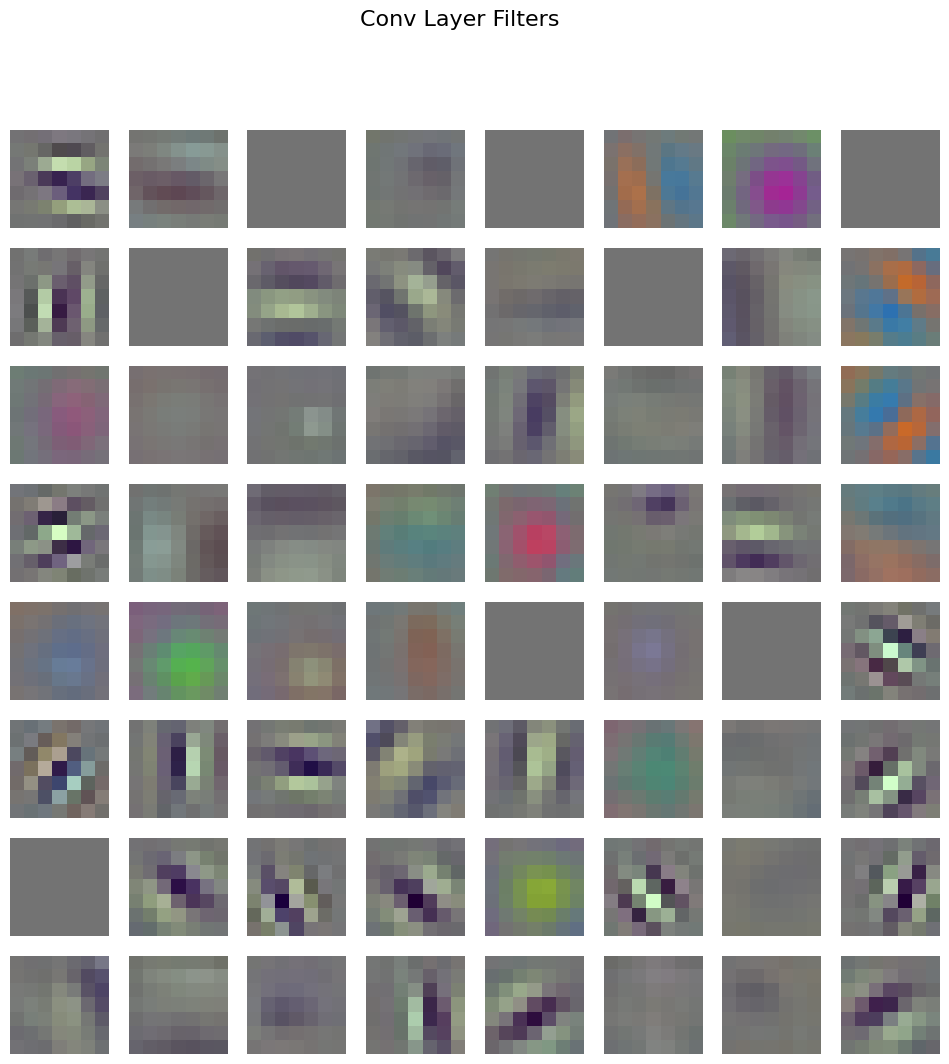

bn1.weight weights shape: torch.Size([64])
bn1.bias weights shape: torch.Size([64])
Visualizing Conv Layer: layer1.0.conv1.weight with shape torch.Size([64, 64, 3, 3])


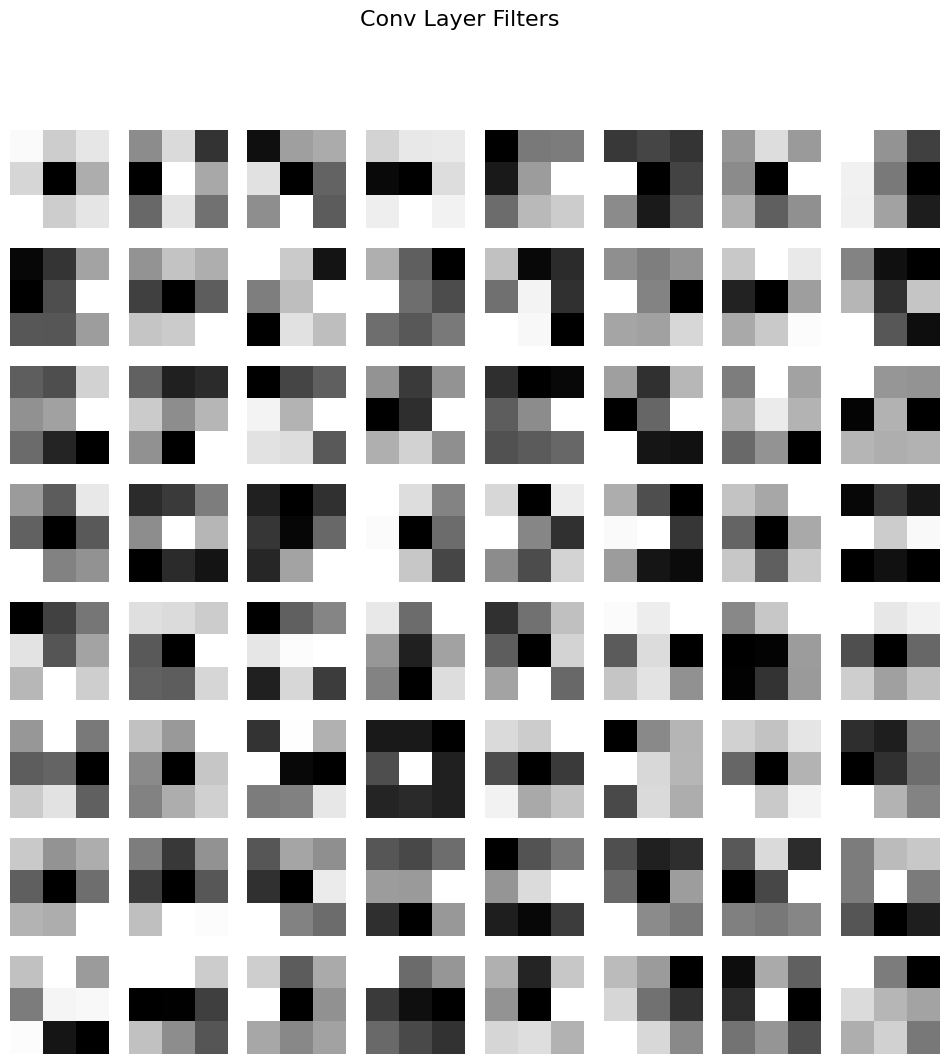

layer1.0.bn1.weight weights shape: torch.Size([64])
layer1.0.bn1.bias weights shape: torch.Size([64])
Visualizing Conv Layer: layer1.0.conv2.weight with shape torch.Size([64, 64, 3, 3])


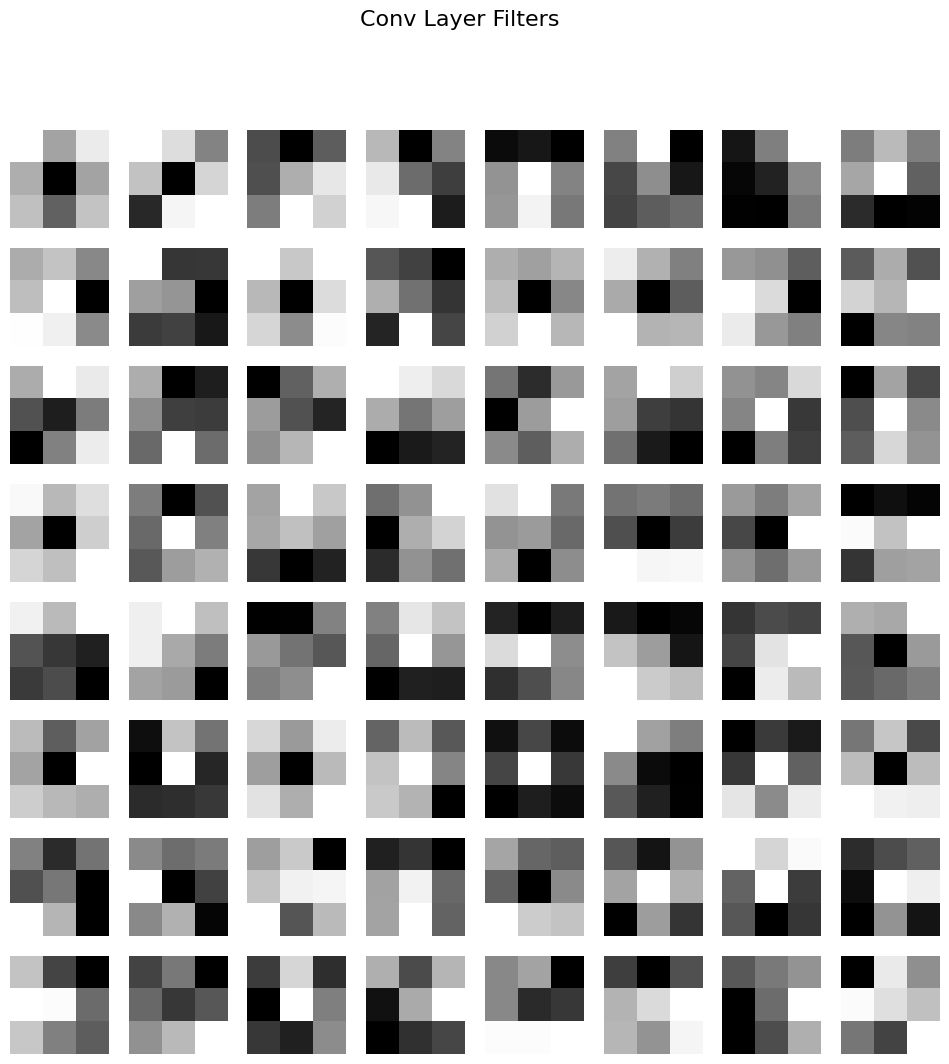

layer1.0.bn2.weight weights shape: torch.Size([64])
layer1.0.bn2.bias weights shape: torch.Size([64])
Visualizing Conv Layer: layer1.1.conv1.weight with shape torch.Size([64, 64, 3, 3])


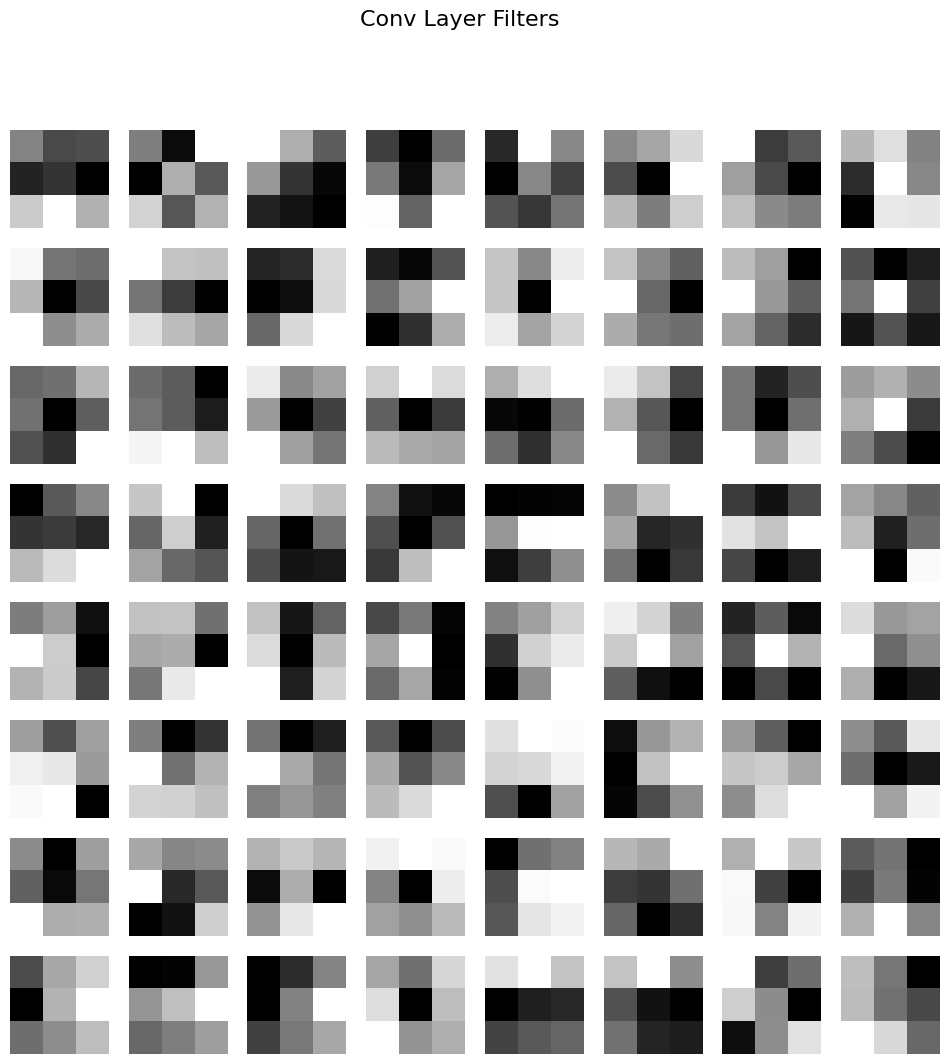

layer1.1.bn1.weight weights shape: torch.Size([64])
layer1.1.bn1.bias weights shape: torch.Size([64])
Visualizing Conv Layer: layer1.1.conv2.weight with shape torch.Size([64, 64, 3, 3])


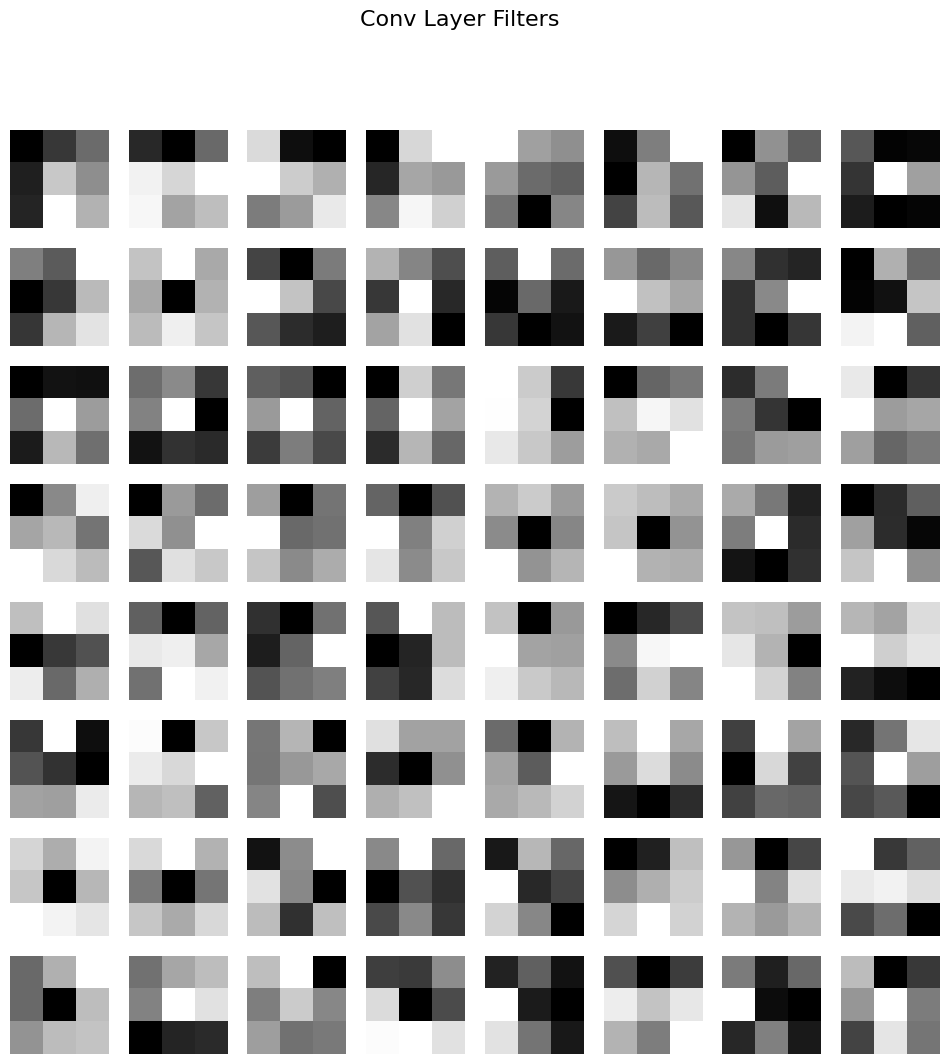

layer1.1.bn2.weight weights shape: torch.Size([64])
layer1.1.bn2.bias weights shape: torch.Size([64])
Visualizing Conv Layer: layer2.0.conv1.weight with shape torch.Size([128, 64, 3, 3])


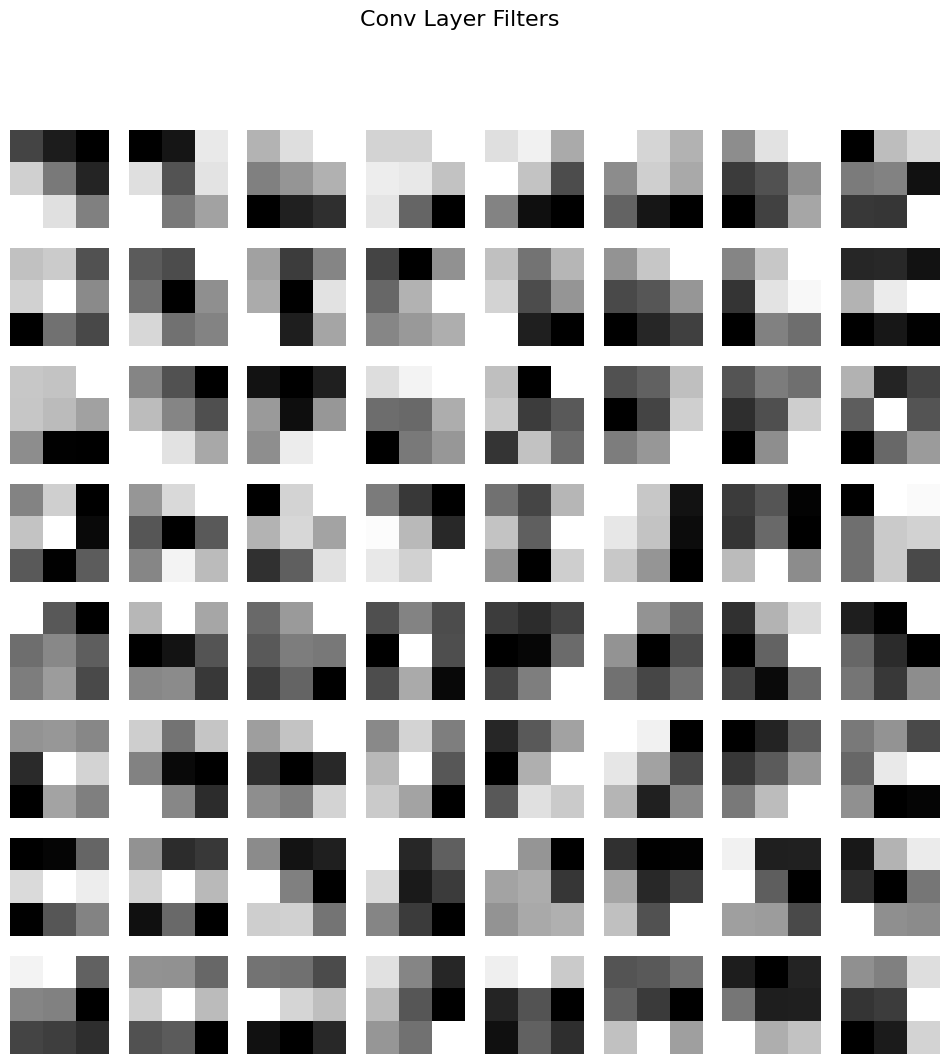

layer2.0.bn1.weight weights shape: torch.Size([128])
layer2.0.bn1.bias weights shape: torch.Size([128])
Visualizing Conv Layer: layer2.0.conv2.weight with shape torch.Size([128, 128, 3, 3])


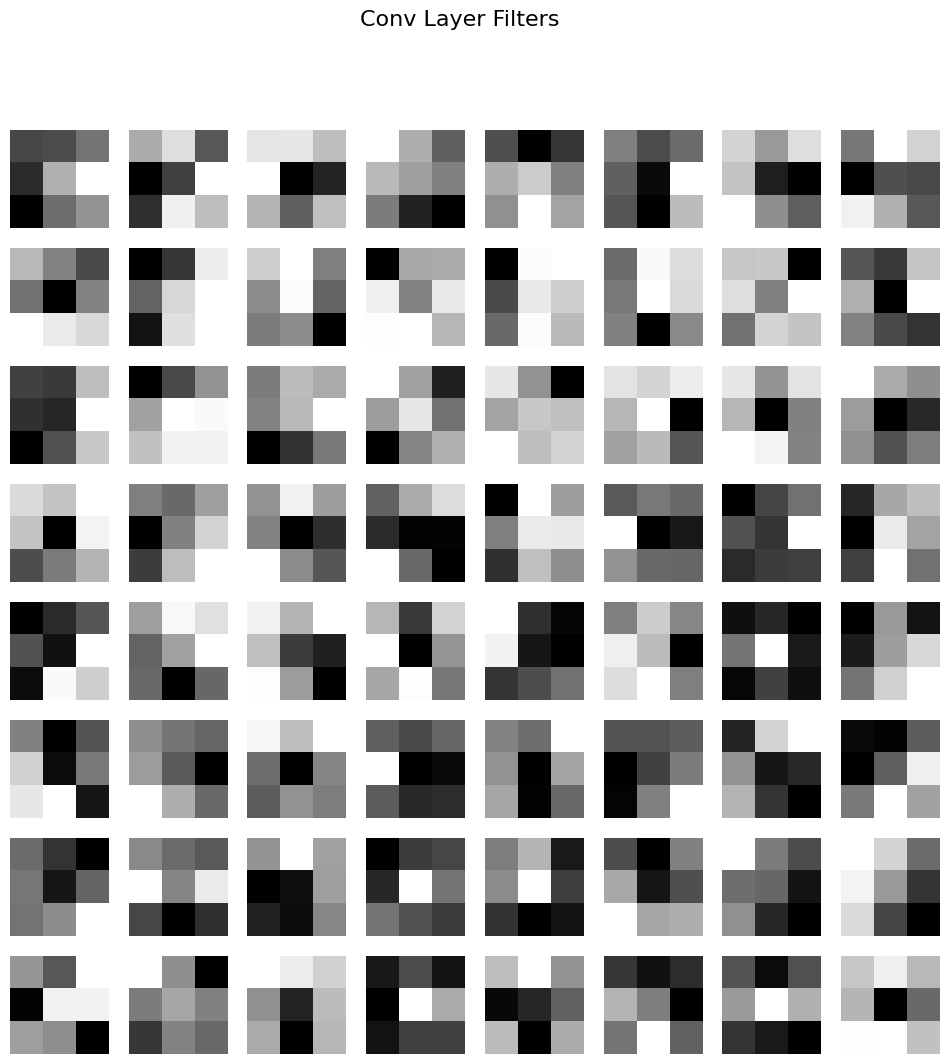

layer2.0.bn2.weight weights shape: torch.Size([128])
layer2.0.bn2.bias weights shape: torch.Size([128])
layer2.0.downsample.0.weight weights shape: torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight weights shape: torch.Size([128])
layer2.0.downsample.1.bias weights shape: torch.Size([128])
Visualizing Conv Layer: layer2.1.conv1.weight with shape torch.Size([128, 128, 3, 3])


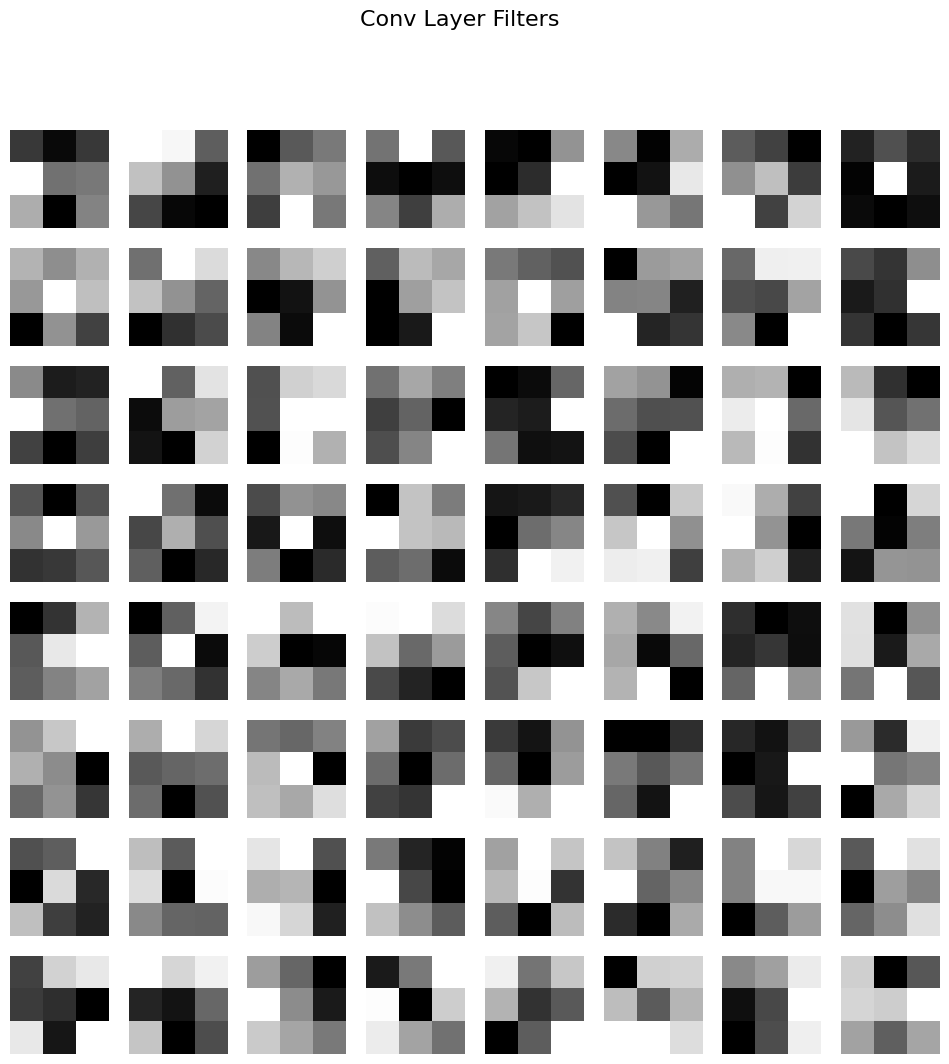

layer2.1.bn1.weight weights shape: torch.Size([128])
layer2.1.bn1.bias weights shape: torch.Size([128])
Visualizing Conv Layer: layer2.1.conv2.weight with shape torch.Size([128, 128, 3, 3])


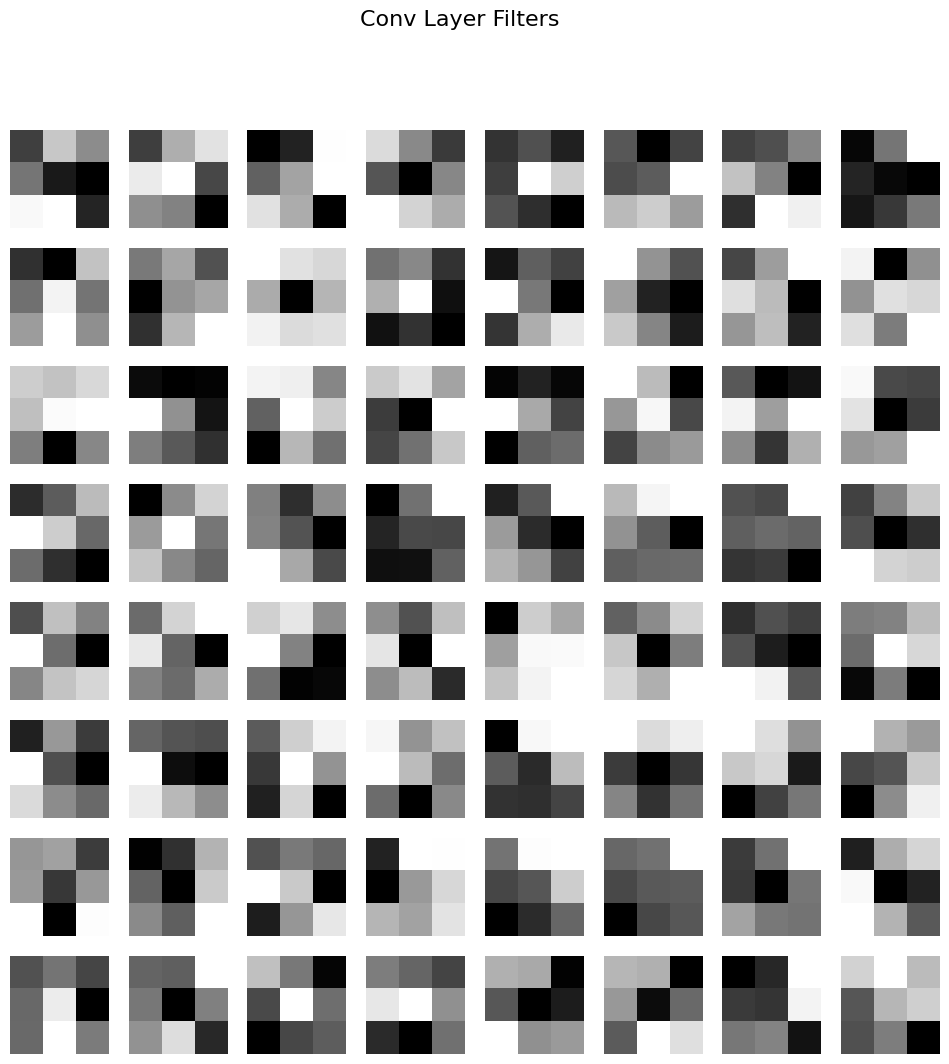

layer2.1.bn2.weight weights shape: torch.Size([128])
layer2.1.bn2.bias weights shape: torch.Size([128])
Visualizing Conv Layer: layer3.0.conv1.weight with shape torch.Size([256, 128, 3, 3])


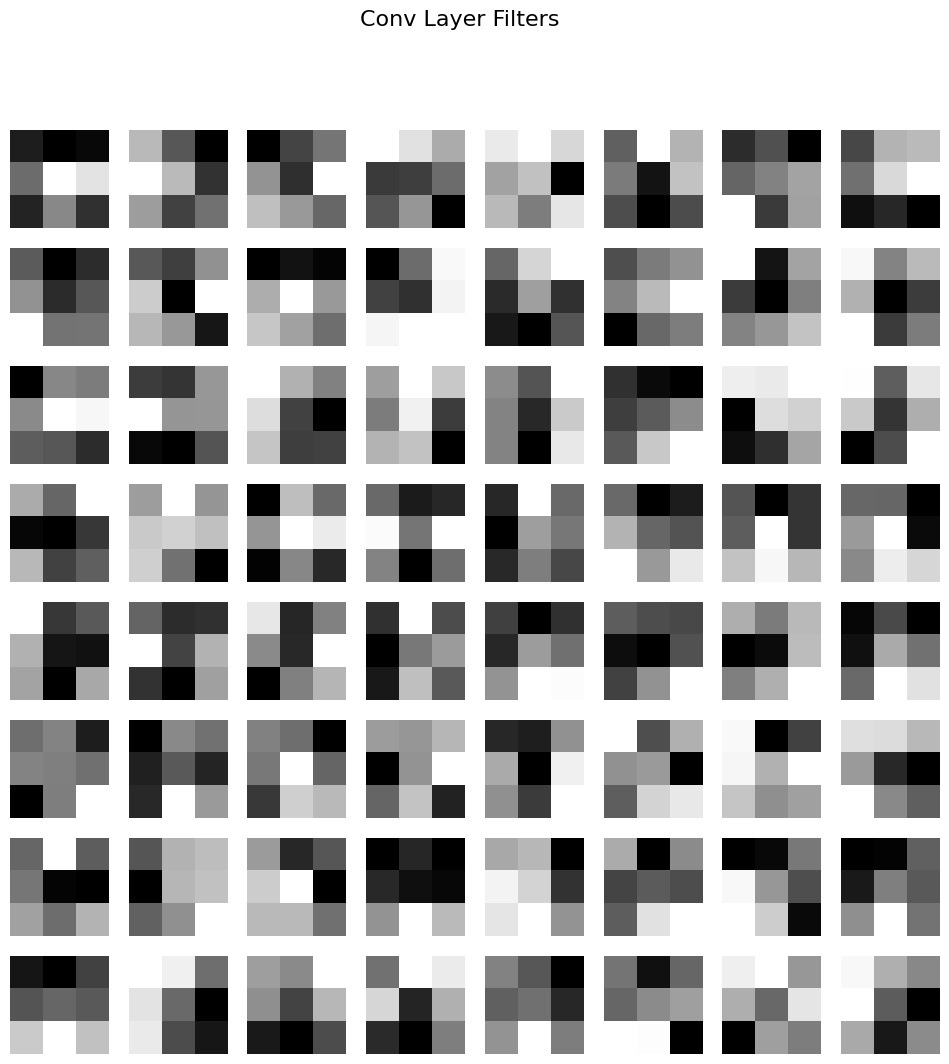

layer3.0.bn1.weight weights shape: torch.Size([256])
layer3.0.bn1.bias weights shape: torch.Size([256])
Visualizing Conv Layer: layer3.0.conv2.weight with shape torch.Size([256, 256, 3, 3])


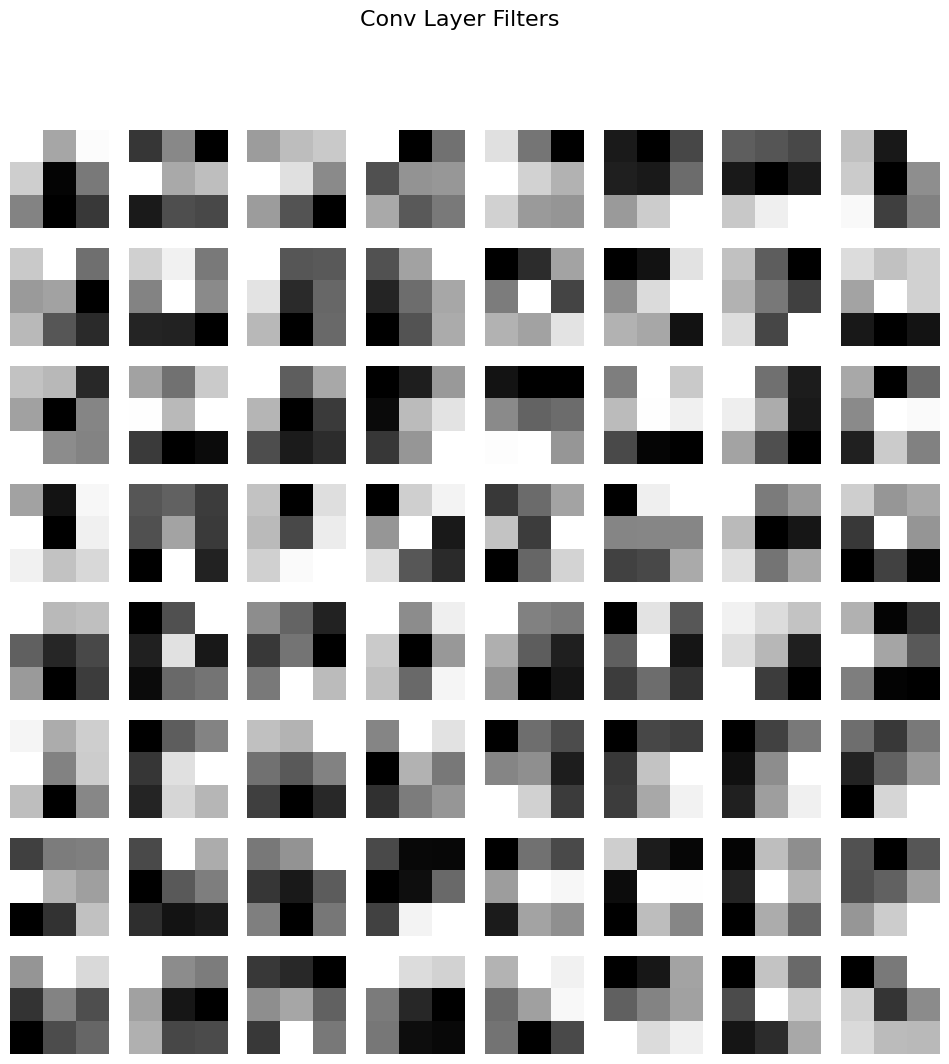

layer3.0.bn2.weight weights shape: torch.Size([256])
layer3.0.bn2.bias weights shape: torch.Size([256])
layer3.0.downsample.0.weight weights shape: torch.Size([256, 128, 1, 1])
layer3.0.downsample.1.weight weights shape: torch.Size([256])
layer3.0.downsample.1.bias weights shape: torch.Size([256])
Visualizing Conv Layer: layer3.1.conv1.weight with shape torch.Size([256, 256, 3, 3])


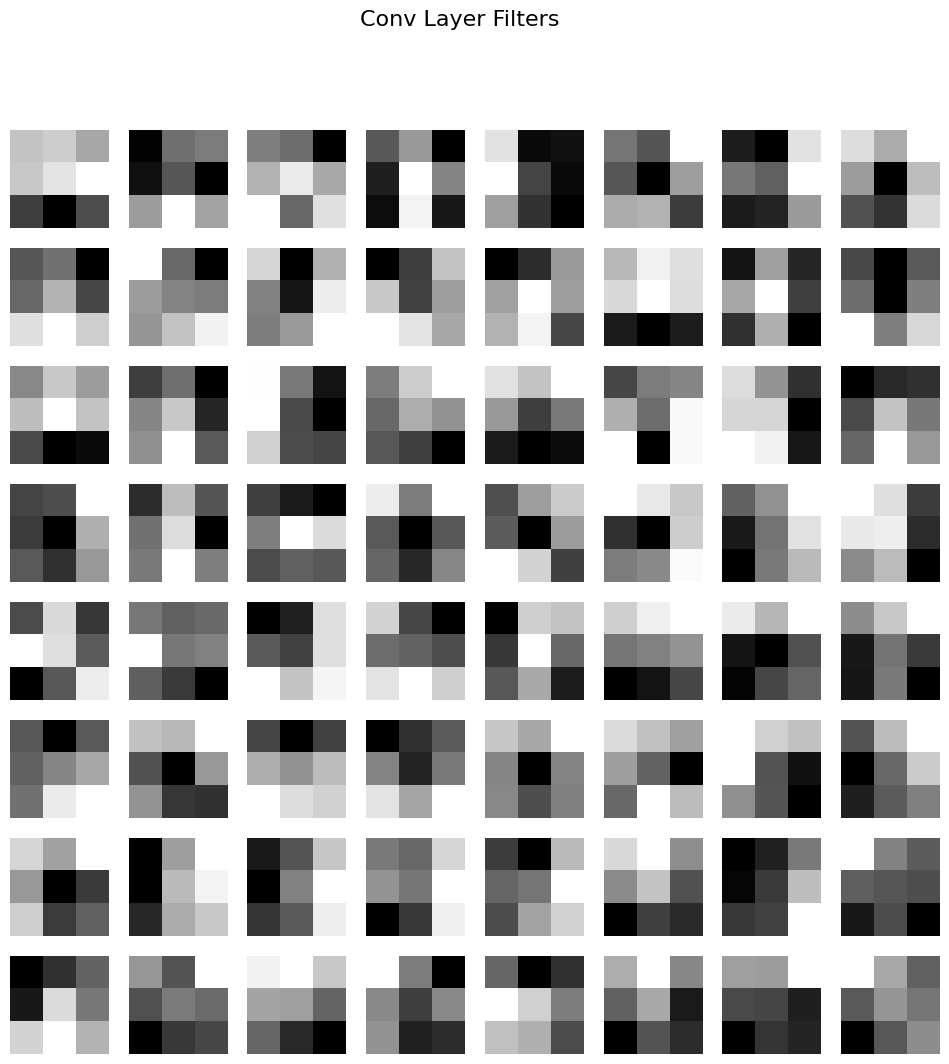

layer3.1.bn1.weight weights shape: torch.Size([256])
layer3.1.bn1.bias weights shape: torch.Size([256])
Visualizing Conv Layer: layer3.1.conv2.weight with shape torch.Size([256, 256, 3, 3])


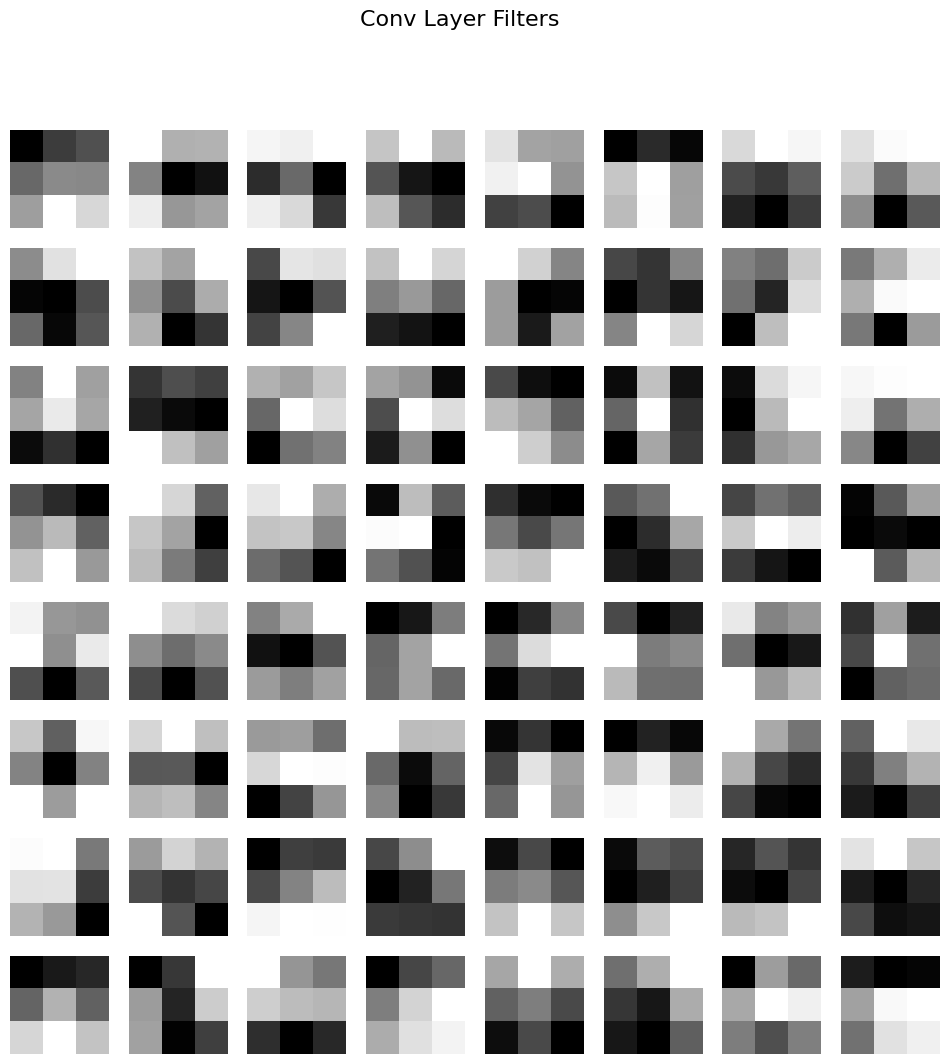

layer3.1.bn2.weight weights shape: torch.Size([256])
layer3.1.bn2.bias weights shape: torch.Size([256])
Visualizing Conv Layer: layer4.0.conv1.weight with shape torch.Size([512, 256, 3, 3])


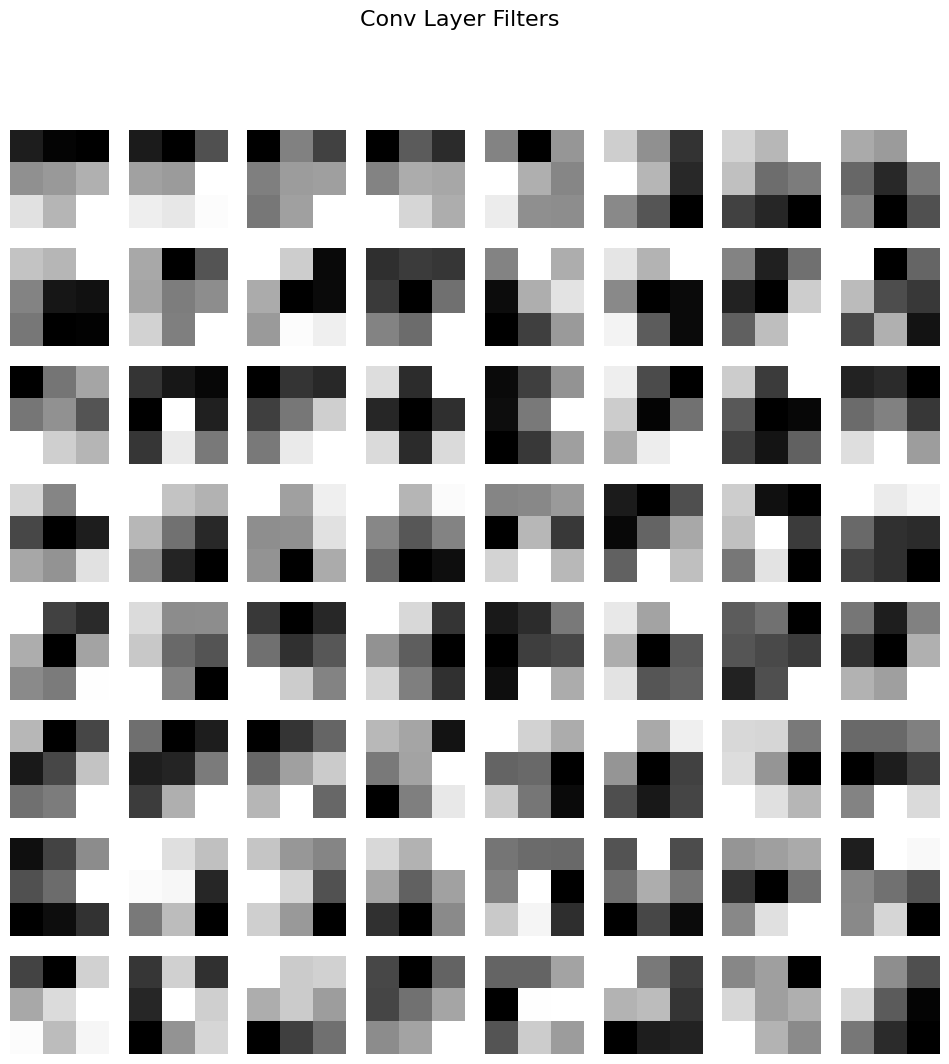

layer4.0.bn1.weight weights shape: torch.Size([512])
layer4.0.bn1.bias weights shape: torch.Size([512])
Visualizing Conv Layer: layer4.0.conv2.weight with shape torch.Size([512, 512, 3, 3])


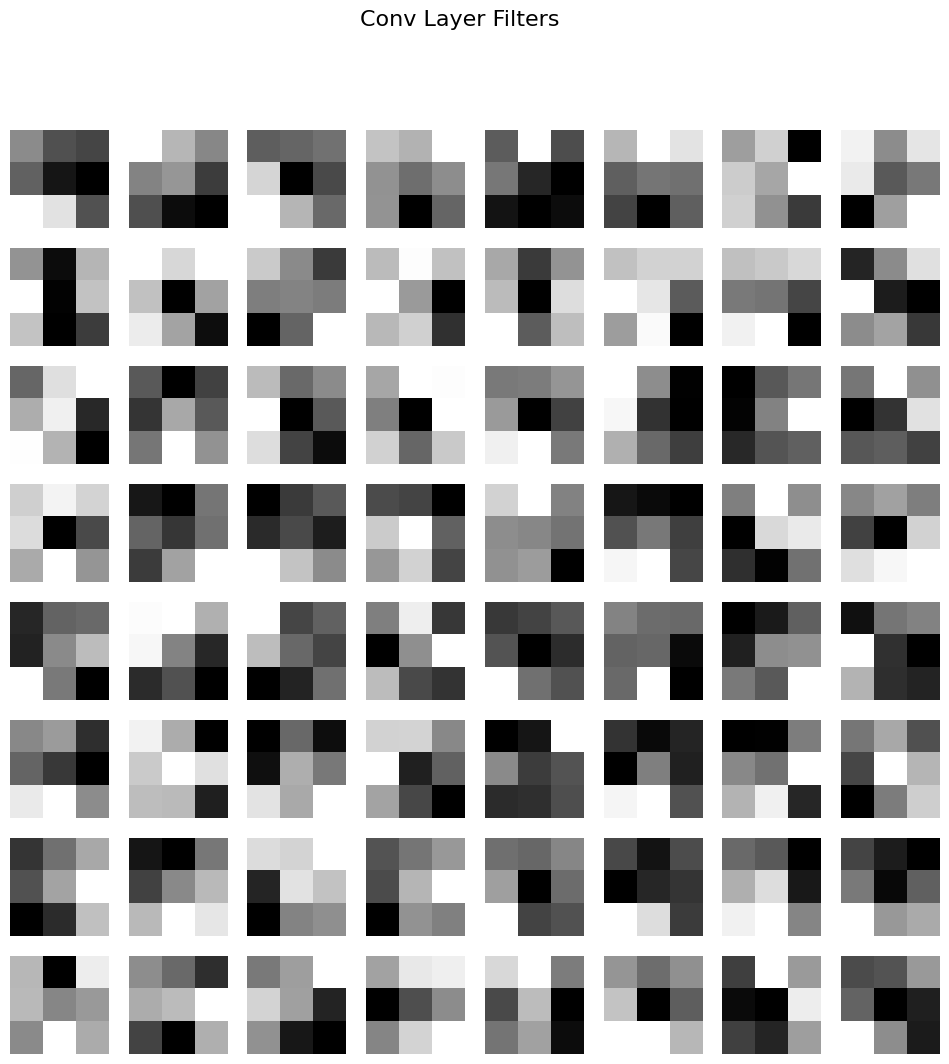

layer4.0.bn2.weight weights shape: torch.Size([512])
layer4.0.bn2.bias weights shape: torch.Size([512])
layer4.0.downsample.0.weight weights shape: torch.Size([512, 256, 1, 1])
layer4.0.downsample.1.weight weights shape: torch.Size([512])
layer4.0.downsample.1.bias weights shape: torch.Size([512])
Visualizing Conv Layer: layer4.1.conv1.weight with shape torch.Size([512, 512, 3, 3])


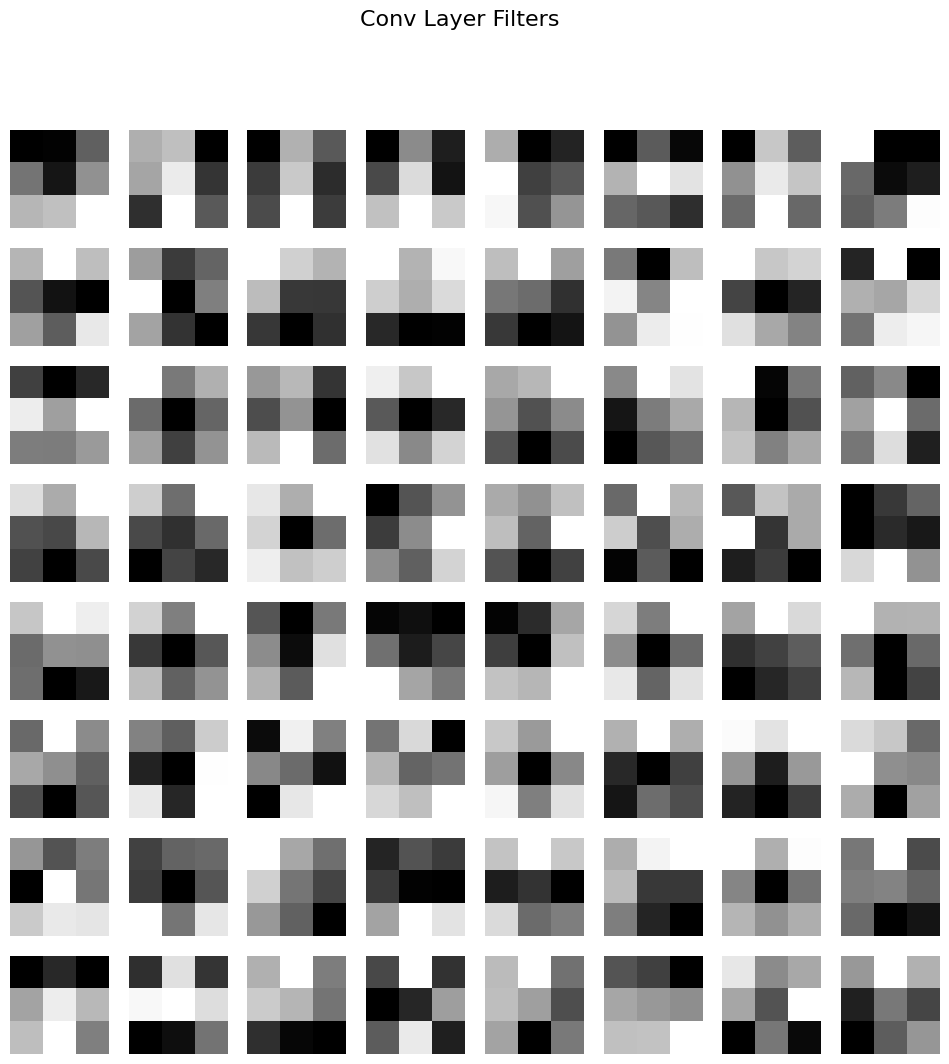

layer4.1.bn1.weight weights shape: torch.Size([512])
layer4.1.bn1.bias weights shape: torch.Size([512])
Visualizing Conv Layer: layer4.1.conv2.weight with shape torch.Size([512, 512, 3, 3])


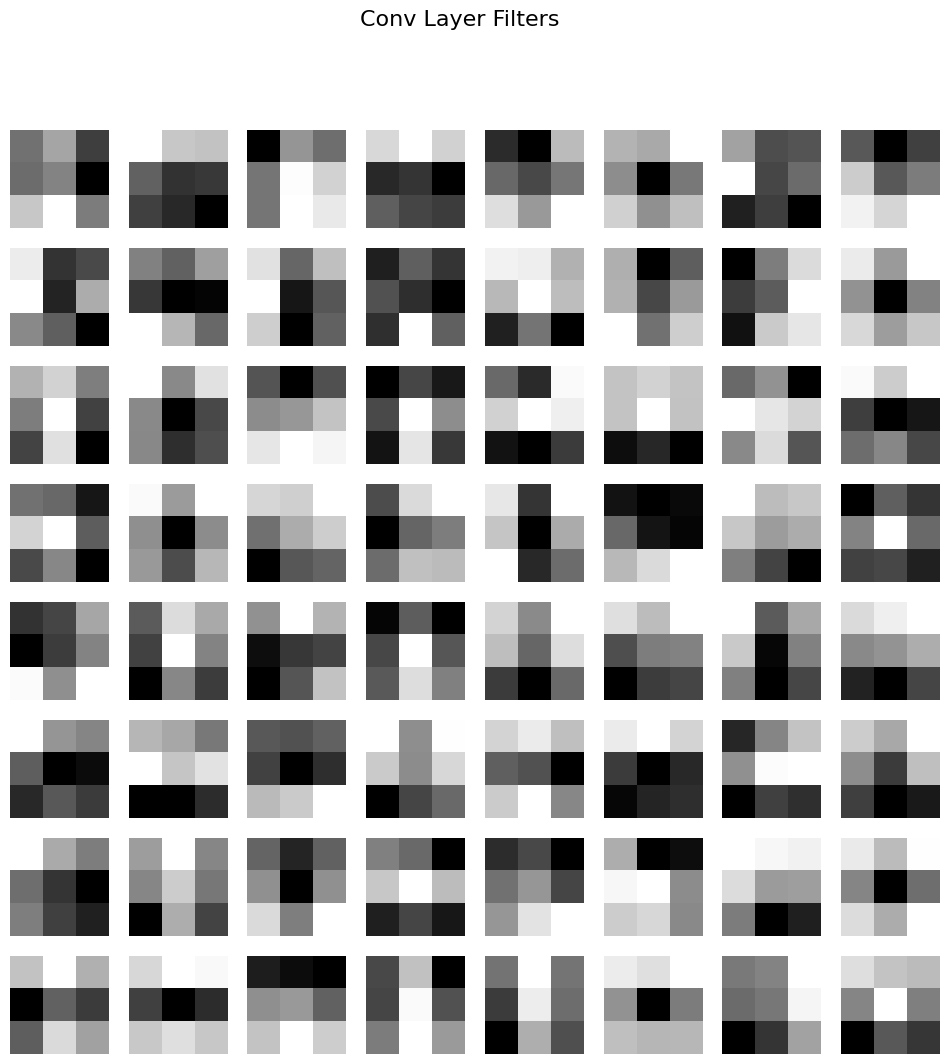

layer4.1.bn2.weight weights shape: torch.Size([512])
layer4.1.bn2.bias weights shape: torch.Size([512])
fc.weight weights shape: torch.Size([50, 512])
fc.bias weights shape: torch.Size([50])


In [45]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load pretrained ResNet34 model

# Iterate through all the layers and print their weights
def visualize_model_weights(model):
    # Loop over all layers' parameters
    for name, param in model.named_parameters():
        if 'conv' in name and len(param.shape) == 4:
            # For convolutional layers, we visualize the filters
            print(f"Visualizing Conv Layer: {name} with shape {param.shape}")
            visualize_conv_weights(param)
        else:
            # For other layers, we just print the shape
            print(f"{name} weights shape: {param.shape}")

# Visualize the convolutional layer's filters
def visualize_conv_weights(weights):
    weights = weights.data.cpu()

    # Normalize weights to [0, 1] for better visualization
    min_weight = weights.min()
    max_weight = weights.max()
    normalized_weights = (weights - min_weight) / (max_weight - min_weight)

    # Plot filters
    n_filters = normalized_weights.shape[0]  # Number of filters
    channels = normalized_weights.shape[1]  # Input channels

    # Create a grid to visualize multiple filters, limit the filters visualized
    grid_size = min(n_filters, 64)  # Limiting to visualize at most 64 filters per layer
    plt.figure(figsize=(12, 12))

    for i in range(grid_size):
        plt.subplot(8, 8, i + 1)
        if channels == 3:  # RGB filters
            plt.imshow(normalized_weights[i].permute(1, 2, 0))
        else:  # Grayscale filters
            plt.imshow(normalized_weights[i][0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Conv Layer Filters", fontsize=16)
    plt.show()

# Call the function to visualize all layers
visualize_model_weights(model)
